In [1]:
from impedancehero import ImpedanceHero as ih

In [2]:
%load_ext autoreload
%autoreload 2

Load data

In [3]:
import os
from tqdm import tqdm
data_915=ih(itype="fri")
data_915.loadfreq_jiang("./../twish_data/20220707-cell1/20220707_Parameter_Test_1.txt")

for root, dirs, files in os.walk("./../twish_data/20220707-cell1/"):
    os.mkdir(os.path.join(root, "processed"))
    for name in tqdm(files):
        if name.split(".")[-1]=="xlsx":
            # print("processing file:", os.path.join(root, name))
            data_915.loadfile(os.path.join(root, name))
            data_915.writefile(os.path.join(root,"processed",name.replace(".xlsx",".csv")))

FileExistsError: [Errno 17] File exists: './../twish_data/20220707-cell1/processed'

100%|██████████| 697/697 [00:17<00:00, 38.83it/s]


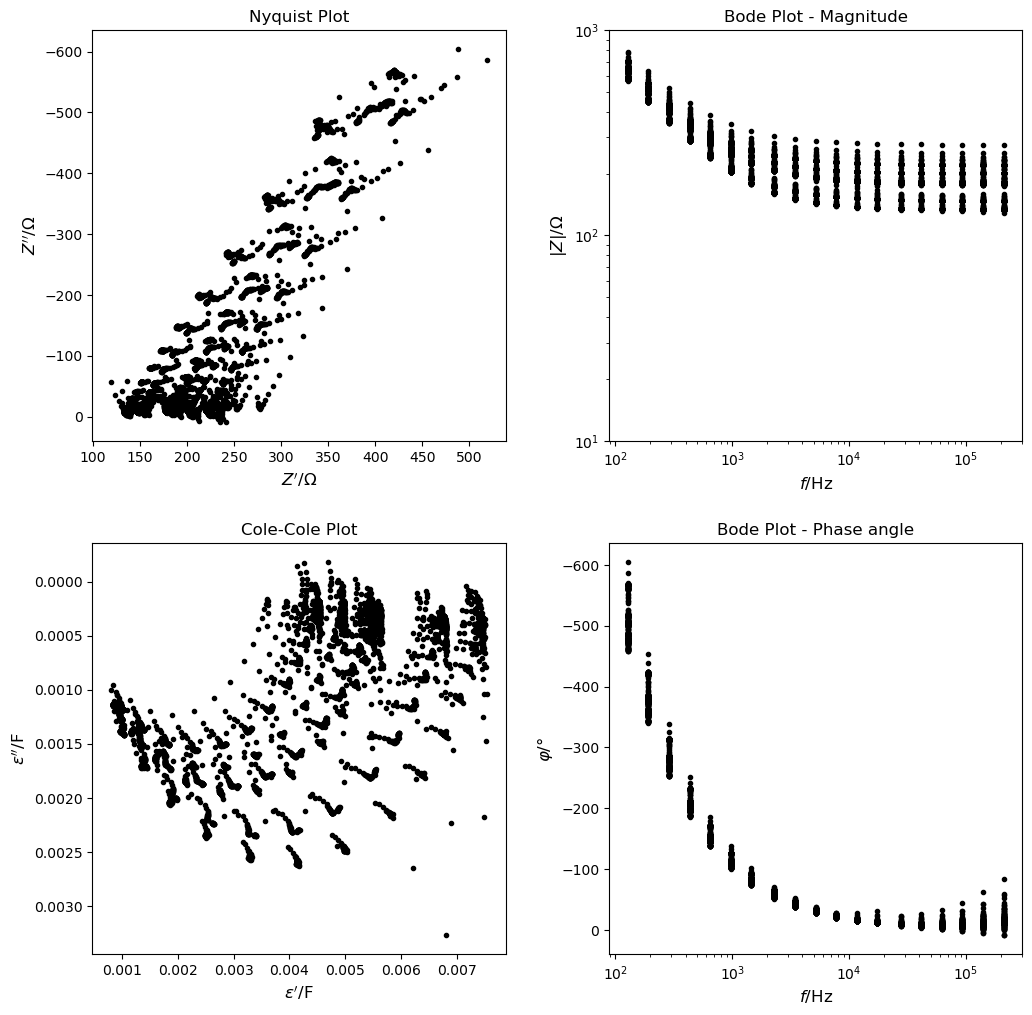

In [5]:
# plot the data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def z2c(z,f):
    # c=1/(2j*np.pi*f*z)
    # c=(2j*np.pi*f*z)
    c=1/z
    return c


data_915=ih(itype="fri")
f=np.array(data_915.loadfreq_jiang("./../twish_data/20210722_concept_4.6M/20210722_Parameter_Test_1.txt"))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for root, dirs, files in os.walk("./../twish_data/20210722_concept_4.6M/"):
    # os.mkdir(os.path.join(root, "processed"))
    for name in tqdm(files):
        if name.split(".")[-1]=="xlsx":
            # print("processing file:", os.path.join(root, name))
            data = data_915.loadfile(os.path.join(root, name))
            if data is None:
                continue
            # data_915.writefile(os.path.join(root,"processed",name.replace(".xlsx",".csv")))
            Z_data=data[:,1]+1j*data[:,2]
            # Z_model=ppal_4(p=df_fit.iloc[i,1:-1].to_dict(),f=f)

            # h_mod,=ax1.plot(Z_model.real, Z_model.imag, color='k', linewidth=1)
            # ax2.loglog(f, np.abs(Z_model), color='k', linewidth=1)
            # ax4.semilogx(f, np.angle(Z_model, deg=True), color='k', linewidth=1)
            # ax3.plot(z2c(Z_model,f).real, z2c(Z_model,f).imag, color='k', linewidth=1)

            # f'{(i+1)/4}h'
            h_dat,=ax1.plot(Z_data.real, Z_data.imag, '.', color='k')
            ax2.loglog(f, np.abs(Z_data), '.',color='k')
            # ax4.semilogx(f, np.angle(Z_data, deg=True), '.',color='k')
            ax4.semilogx(f, np.imag(Z_data), '.',color='k')
            ax3.plot(z2c(Z_data,f).real, z2c(Z_data,f).imag, '.',color='k')

            # legend_handle.append(extra)
            # legend_handle.append(h_mod)
            # legend_handle.append(h_dat)
            # legend_labels.append(f'{(i+1)/4}h')
            # legend_labels.append('')
            # legend_labels.append('')

# ax1.legend(legend_labels, loc='upper left', fontsize=12)
# ax2.legend(legend_labels, loc='upper right', fontsize=12)
# ax3.legend(legend_labels, loc='upper left', fontsize=12)
# ax4.legend(legend_labels, loc='upper right', fontsize=12)


ax1.set_xlabel(r"$Z'/\Omega$",fontdict={'fontsize': 12})
ax1.set_ylabel(r"$Z''/\Omega$",fontdict={'fontsize': 12})
ax1.set_title("Nyquist Plot")
ax1.invert_yaxis()
    
ax2.set_xlabel(r"$f/$Hz",fontdict={'fontsize': 12})
ax2.set_ylabel(r"$|Z|/\Omega$",fontdict={'fontsize': 12})
ax2.set_ybound(10,1e3)
ax2.set_title("Bode Plot - Magnitude")

ax4.set_xlabel(r"$f/$Hz",fontdict={'fontsize': 12})
ax4.set_ylabel(r"$\varphi/\degree$",fontdict={'fontsize': 12})
ax4.set_title("Bode Plot - Phase angle")
ax4.invert_yaxis()

ax3.set_xlabel(r"$\varepsilon'/$F",fontdict={'fontsize': 12})
ax3.set_ylabel(r"$\varepsilon''/$F",fontdict={'fontsize': 12})
ax3.set_title("Cole-Cole Plot")
ax3.invert_yaxis()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.25, wspace=0.25)
fig.savefig("fitting.svg", format="svg")
# Show the plot
plt.show()


In [205]:
import lmfit
import numpy as np
from eq_models import twish_5

p=lmfit.Parameters()
p.add('rl',10,min=0, max=1000)
p.add('cw',1e-5,min=0,max=1)
# p.add('R2',0,min=0, max=0)
# p.add('C2',1e-3,min=1e-10, max=1e-2)
p.add('rw', 1,min=0, max=1000)
p.add('d', 1,min=0, max=1000)
p.add('D', 100,min=0, max=100000)
p.add('Q', 1e-5,min=0, max=1e-3)
p.add('n', 0.8,min=0, max=1)
p.add('L', 1e-6,min=0, max=1e-4)
p.add('Cs', 2e-10,min=0, max=1e-9)
# p.add('Cs', 1e-9,min=1e-15, max=1e-4)

def objective(p, f, Z_data):
    Z_model=twish_5(p,f)
    # out=np.nanmean(np.abs(np.log(Z_model)-np.log(Z_data)))
    out=np.nanmean(np.abs(np.log(Z_model)-np.log(Z_data))**2)
    return out
    
# def my_penalty(p):
#     Z_cpe=1 / ( p['Q0'] * ((2j * np.pi * 1000) ** p['n0'])) + p['R0']
#     Z_cc=1 / ( 1 / ( p['R1'] ) + 1 / ( ( p['R2'] + 1 / ( p['Q1'] * ((2j * np.pi * f) ** p['n1'])) ) ) )
#     return np.abs(1/Z_cc)*0.1

In [206]:
# fit all files
import lmfit
from tqdm import tqdm
import csv
from impedancehero import ImpedanceHero as ih
import os
from sklearn.metrics import r2_score
from eq_models import twish_5

DATE = "20210722"
# DATE = "20210707"

DATE_Last4 = DATE[-4:]
# folder="./../repaired_data/2019.7.12 Cell growth/Cell Growth/"
# folder="./../repaired_data/9.20 Cell Growth/"
# folder="./../repaired_data/9.15 Cell Growth/"
# folder="./../repaired_data/8.15 Cell Growth/8.16 2.00pm/"
# folder="./../repaired_data/8.15 Cell Growth/8.16 after 2pm/"
# folder="./../repaired_data/8.20 Cell Growth/"
folder = "./../twish_data/20210722_concept_4.6M/"
# folder="./../twish_data/20210707-cell1/"

fit_model=twish_5


# for sensor in range(8):
sensor = 4

p=lmfit.Parameters()
p.add('rl',10,min=0, max=1000)
p.add('cw',1e-5,min=0,max=1)
# p.add('R2',0,min=0, max=0)
# p.add('C2',1e-3,min=1e-10, max=1e-2)
p.add('rw', 1,min=0, max=1000)
p.add('d', 1,min=0, max=1000)
p.add('D', 100,min=0, max=100000)
p.add('Q', 1e-5,min=0, max=1e-3)
p.add('n', 0.8,min=0, max=1)
p.add('L', 1e-6,min=0, max=1e-4)
p.add('Cs', 2e-10,min=0, max=1e-9)

# p.add('R1',10,min=0, max=1000)
# p.add('C1',1e-5,min=1e-7,max=1e-3)
# p.add('d',10,min=0, max=1e5)
# p.add('rl',1,min=0, max=100)
# p.add('Q', 1e-6,min=1e-10, max=1e-4)
# p.add('n', 1,min=0, max=1)
# p.add('Rl', 100,min=50, max=1000)
# p.add('Cs', 2e-10,min=0, max=1e-9)

data_915=ih(itype="fri")
data_915.loadfreq_jiang(folder+f"{DATE}_Parameter_Test_1.txt")

# calib_file=f"./../repaired_data/8.15 Cell Growth/SYS/20190814_Sensor{sensor}_Test_3.xlsx"
# data_sys=data_915.loadfile(calib_file,screen=1)
# Z_sys=data_sys[:,1]+1j*data_sys[:,2]

f=None
Z=None
first_fit=True

results=[]

for root, dirs, files in os.walk(folder):
    filenames=[]
    for name in tqdm(files):
        if name.split(".")[-1]=="xlsx":
            if name.split('_')[1]== f"Sensor{sensor}":
                try:
                    file_index=int(name.split('.')[0].split('_')[-1])
                except:
                    continue
                filenames.append((file_index,name))
    for index, name in tqdm(sorted(filenames,key=lambda x:x[0],reverse=True)):
        # print(name)
        # if index<23:
        #     continue
        data=data_915.loadfile(os.path.join(root, name), screen=0.005)
        if data is None:
            pass #keep f and Z the same as previous
        else:
            f=data[:,0]
            Z=data[:,1]+1j*data[:,2]
        # Z=Z-Z_sys

        mini=lmfit.Minimizer(objective, params=p, fcn_args=(f,Z), nan_policy='omit')
        
        if first_fit:
            # guess based on raw data
            if data is None:
                result=p.valuesdict()
                result.update({'rl':np.nan,'cw':np.nan,'rw':np.nan,'d':np.nan,'D':np.nan,'Q':np.nan,'n':np.nan,'L':np.nan,'Cs':np.nan})
                results.append(result)
                continue
            else:
                fl,Zl=sorted(zip(f,Z))[0]
                fh,Zh=sorted(zip(f,Z))[-1]
                n1_guess=np.angle(np.conj(Zl-Zh),deg=True)/90
                Q1_guess=np.abs(1/((Zl-Zh)*(2j*np.pi*fl)**n1_guess))
                Rl_guess=np.abs(Zh)
                # R2_guess=3*R1_guess
                # C2_guess=1e-5/R2_guess
                p.add('rl',10,min=0, max=1000)
                p.add('cw',1e-5,min=0,max=1)
                # p.add('R2',0,min=0, max=0)
                # p.add('C2',1e-3,min=1e-10, max=1e-2)
                p.add('rw', 1,min=0, max=1000)
                p.add('d', 1,min=0, max=1000)
                p.add('D', Rl_guess/10,min=0, max=100000)
                p.add('Q', Q1_guess,min=0, max=1e-3)
                p.add('n', n1_guess,min=0, max=1)
                p.add('L', 1e-6,min=0, max=1e-4)
                p.add('Cs', 2e-10,min=0, max=1e-9)
                
                out1=mini.minimize(params=p, method='basinhopping')
                out2=mini.minimize(params=out1.params, method='lstsq')

                p=out2.params
                rmse= np.sqrt(np.nanmean((np.abs(fit_model(p,f))-np.abs(Z))**2))
                result=p.valuesdict()
                result.update({'rmse': rmse})
                first_fit=False
        else:
            # out1=mini.minimize(params=p, method='slsqp')
            # Keep the proportion of R1 and Rl the same
            # proportion=p['R1'].value/p['Rl'].value
            # p['R1'].set(value=proportion*p['Rl'].value)

            out2=mini.minimize(params=p, method='lbfgsb')
        # get fitting rmse
        p=out2.params
        rmse= np.sqrt(np.nanmean((np.abs(fit_model(p,f))-np.abs(Z))**2))
        
        if rmse < 1:
            result=p.valuesdict()
            result.update({'rmse': rmse})
            results.append(result)
        else:
            
            # result=p.valuesdict()
            # continue

            # results.append(result)
            # continue
            # print(f'deviation at {index}!')
            # fl,Zl=sorted(zip(f,Z))[0]
            # fh,Zh=sorted(zip(f,Z))[-1]
            # n1_guess=np.angle(np.conj(Zl-Zh),deg=True)/90
            # Q1_guess=np.abs(1/((Zl-Zh)*(2j*np.pi*fl)**n1_guess))
            # R1_guess=np.abs(Zh)
            # R2_guess=3*R1_guess
            # C2_guess=1e-4/R2_guess
            
            fl,Zl=sorted(zip(f,Z))[0]
            fh,Zh=sorted(zip(f,Z))[-1]
            n1_guess=np.angle(np.conj(Zl-Zh),deg=True)/90
            Q1_guess=np.abs(1/((Zl-Zh)*(2j*np.pi*fl)**n1_guess))
            Rl_guess=np.abs(Zh)
            # R2_guess=3*R1_guess
            # C2_guess=1e-5/R2_guess
            p.add('rl',10,min=0, max=1000)
            p.add('cw',1e-5,min=0,max=1)
            # p.add('R2',0,min=0, max=0)
            # p.add('C2',1e-3,min=1e-10, max=1e-2)
            p.add('rw', 1,min=0, max=1000)
            p.add('d', 1,min=0, max=1000)
            p.add('D', Rl_guess/10,min=0, max=100000)
            p.add('Q', Q1_guess,min=0, max=1e-3)
            p.add('n', n1_guess,min=0, max=1)
            p.add('L', 1e-6,min=0, max=1e-4)
            p.add('Cs', 2e-10,min=0, max=1e-9)
            
            out1=mini.minimize(params=p, method='differential_evolution')
            out2=mini.minimize(params=p, method='lstsq')
            p=out2.params
            rmse= np.sqrt(np.nanmean((np.abs(fit_model(p,f))-np.abs(Z))**2))
            if rmse < 1:
                result=p.valuesdict()
                result.update({'rmse': rmse})
                results.append(result)
            else:
                results.append(None)
    break

if not os.path.exists(f'./features{DATE_Last4}'):
    os.makedirs(f'./features{DATE_Last4}')

with open(f'./features{DATE_Last4}/{DATE_Last4}_results_s{sensor}.csv', 'w', newline='') as csv_file:
    fieldnames = ['index', 'R1', 'C1', 'Q', 'n', 'Rl', 'Cs', 'rmse']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for i, result in enumerate(reversed(results)):
        if result is None:
            row = {'index': i+1 }
            row.update({'rmse': np.nan})
            row.update({'R1': np.nan})
            row.update({'C1': np.nan})
            row.update({'Q': np.nan})
            row.update({'n': np.nan})
            row.update({'Rl': np.nan})
            row.update({'Cs': np.nan})
            writer.writerow(row)

        else:    
            row = {'index': i+1 }
            row.update(result)
            writer.writerow(row)



  2%|▏         | 2/87 [00:16<10:28,  7.40s/it]/Users/zincarrot/opt/anaconda3/lib/python3.9/site-packages/lmfit/parameter.py:908: RuntimeWarning: divide by zero encountered in true_divide
  return self._getval() / other
/Users/zincarrot/opt/anaconda3/lib/python3.9/site-packages/lmfit/parameter.py:908: RuntimeWarning: invalid value encountered in true_divide
  return self._getval() / other
/var/folders/tx/94jf20c57v15dzmr3gt79w7r0000gn/T/ipykernel_5033/1438776582.py:22: RuntimeWarning: Mean of empty slice
  out=np.nanmean(np.abs(np.log(Z_model)-np.log(Z_data))**2)
  2%|▏         | 2/87 [00:19<13:51,  9.79s/it]


ValueError: The user-provided objective function must return a scalar value.

In [ ]:
# regression
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_predict
#load features
df=pd.read_csv("./features1/0915_results2_s0.csv")
#convert to Qnfed
tau=df['C2']*df['R2']
sh=(1/df['R1'])+(1/df['R2'])
s0=1/df['R1']
df['tau']=tau
df['sh']=sh
df['s0']=s0

measure_data = pd.read_excel(r'./../repaired_data/Cell count/9-15 cell density.xlsx').to_numpy()
measure_data = measure_data[:,2].reshape(9,3).astype(np.float)
measure_data_norm = np.log10(measure_data)

times=[1,13,25,81,93,105,117,129,175]
# input=df.loc[:,['n1','Q1','tau','C2', 's0', 'sh']].iloc[times,:].values
input=df.loc[:,['C2','tau']].iloc[times,:].values
input=np.log10(input)
# print(input)


idx=[0,2,3,4,5,6,7]
xx = input[idx,]
# yy = np.hstack((measure_data_norm[idx,0], measure_data_norm[idx,1], measure_data_norm[idx,2]))
# xx = np.vstack((xx,xx,xx))

yy = np.mean(measure_data_norm,axis=1)[idx]

regr=LinearRegression(fit_intercept=True)

# selector = RFE(regr, n_features_to_select=3, step=3)
# selector.fit(xx,yy)
# print(selector.ranking_)

regr.fit(xx,yy)
y_pred= regr.predict(xx)
y_hat = regr.predict(xx)

cv_pred = cross_val_predict(regr, xx, y=yy, cv=KFold(yy.size), n_jobs=1)

yy=10**yy
y_hat=10**y_hat
cv_pred=10**cv_pred
print(regr.coef_)
print(regr.intercept_)
print('Training R2 is '+str(1-np.var(y_hat-yy)/np.var(yy)))
print('Testing R2 is '+str(1-np.var(cv_pred-yy)/np.var(yy)))
print('RMSE is '+str(np.sqrt(np.mean(cv_pred-yy)**2)))



[ 1.70082668 -3.9140441 ]
-1.0354597734506656
Training R2 is 0.963706718466034
Testing R2 is 0.9369956505503514
RMSE is 6728.522656922204


/var/folders/tx/94jf20c57v15dzmr3gt79w7r0000gn/T/ipykernel_19920/512079630.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  measure_data = measure_data[:,2].reshape(9,3).astype(np.float)


In [ ]:
10**-1.0354597734506656

0.09215952475902173

In [113]:
# cole-cole plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

def z2c(z,f):
    c=1/(2j*np.pi*f*z)
    return c



/Users/zincarrot/Documents/GitHub/Impedance_fit/python/eq_models.py:70: RuntimeWarning: invalid value encountered in power
  Zcpe=1/((2j*np.pi*f)**n*Q)
/Users/zincarrot/Documents/GitHub/Impedance_fit/python/eq_models.py:70: RuntimeWarning: invalid value encountered in power
  Zcpe=1/((2j*np.pi*f)**n*Q)
/Users/zincarrot/Documents/GitHub/Impedance_fit/python/eq_models.py:70: RuntimeWarning: invalid value encountered in power
  Zcpe=1/((2j*np.pi*f)**n*Q)
/Users/zincarrot/Documents/GitHub/Impedance_fit/python/eq_models.py:70: RuntimeWarning: invalid value encountered in power
  Zcpe=1/((2j*np.pi*f)**n*Q)
/Users/zincarrot/Documents/GitHub/Impedance_fit/python/eq_models.py:70: RuntimeWarning: invalid value encountered in power
  Zcpe=1/((2j*np.pi*f)**n*Q)


IndexError: single positional indexer is out-of-bounds

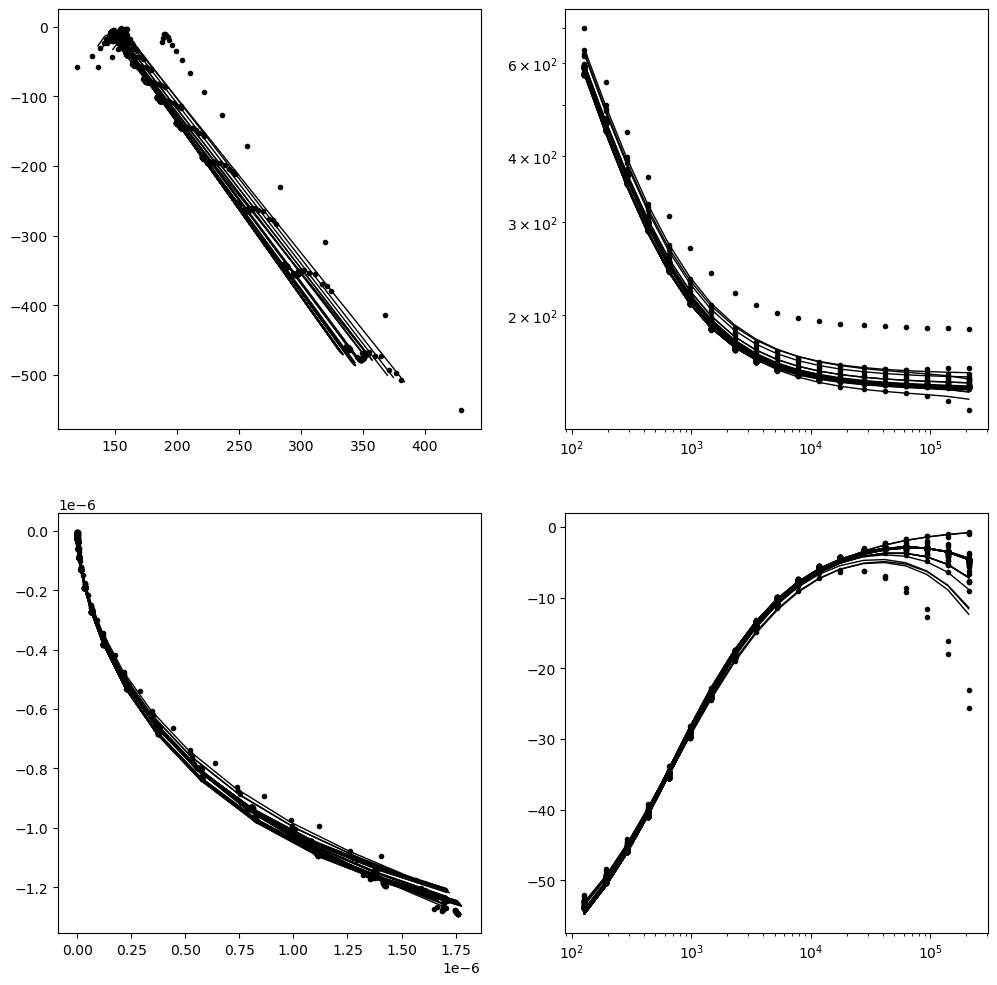

In [192]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

def z2c(z,f):
    c=1/(2j*np.pi*f*z)
    return c

sensor = 0

# impedance spectra
folder="./../twish_data/20210722_concept_4.6M/"
times=list(range(1,88))
df_fit=pd.read_csv(f"./features0722/0722_results_s{sensor}.csv",dtype=float)
ih_plot=ih()

f=np.array(ih_plot.loadfreq_jiang(folder+f"{DATE}_Parameter_Test_1.txt"))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
# legend_handle=[extra,extra,extra]
legend_labels=["fit", "data"]

for idx, i in enumerate(times):
    data=ih_plot.loadfile(folder+f"{DATE}_Sensor{sensor}_Test_{i}.xlsx")
    if data is None:
        continue
    Z_data=data[:,1]+1j*data[:,2]
    Z_model=twish_3(p=df_fit.iloc[i,1:-1].to_dict(),f=f)

    h_mod,=ax1.plot(Z_model.real, Z_model.imag, color='k', linewidth=1)
    ax2.loglog(f, np.abs(Z_model), color='k', linewidth=1)
    ax4.semilogx(f, np.angle(Z_model, deg=True), color='k', linewidth=1)
    ax3.plot(z2c(Z_model,f).real, z2c(Z_model,f).imag, color='k', linewidth=1)

    # f'{(i+1)/4}h'
    h_dat,=ax1.plot(Z_data.real, Z_data.imag, '.', color='k')
    ax2.loglog(f, np.abs(Z_data), '.',color='k')
    ax4.semilogx(f, np.angle(Z_data, deg=True), '.',color='k')
    ax3.plot(z2c(Z_data,f).real, z2c(Z_data,f).imag, '.',color='k')

    # legend_handle.append(extra)
    # legend_handle.append(h_mod)
    # legend_handle.append(h_dat)
    # legend_labels.append(f'{(i+1)/4}h')
    # legend_labels.append('')
    # legend_labels.append('')

ax1.legend(legend_labels, loc='upper left', fontsize=12)
ax2.legend(legend_labels, loc='upper right', fontsize=12)
ax3.legend(legend_labels, loc='upper left', fontsize=12)
ax4.legend(legend_labels, loc='upper right', fontsize=12)


ax1.set_xlabel(r"$Z'/\Omega$",fontdict={'fontsize': 12})
ax1.set_ylabel(r"$Z''/\Omega$",fontdict={'fontsize': 12})
ax1.set_title("Nyquist Plot")
ax1.invert_yaxis()
    
ax2.set_xlabel(r"$f/$Hz",fontdict={'fontsize': 12})
ax2.set_ylabel(r"$|Z|/\Omega$",fontdict={'fontsize': 12})
ax2.set_ybound(10,1e3)
ax2.set_title("Bode Plot - Magnitude")

ax4.set_xlabel(r"$f/$Hz",fontdict={'fontsize': 12})
ax4.set_ylabel(r"$\varphi/\degree$",fontdict={'fontsize': 12})
ax4.set_title("Bode Plot - Phase angle")
ax4.invert_yaxis()

ax3.set_xlabel(r"$\varepsilon'/$F",fontdict={'fontsize': 12})
ax3.set_ylabel(r"$\varepsilon''/$F",fontdict={'fontsize': 12})
ax3.set_title("Cole-Cole Plot")
ax3.invert_yaxis()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.25, wspace=0.25)
fig.savefig("fitting.svg", format="svg")
# Show the plot
plt.show()

IndexError: list index out of range

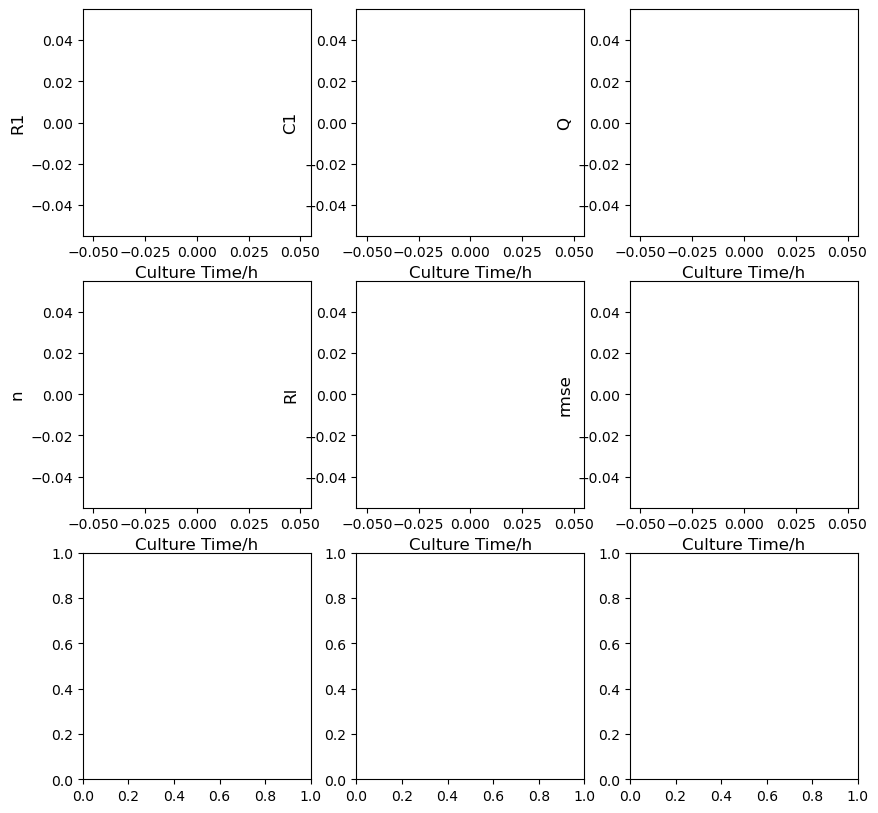

In [200]:
# plot trend
import pandas as pd
from matplotlib import pyplot as plt

sensor=4

result=pd.read_csv(f'./features{DATE_Last4}/{DATE_Last4}_results_s{sensor}.csv')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

x=result['index']/4
y=[]
titles=[]
y.append(result['R1'])
y.append(result['C1'])
# y.append(result['R2'])
# y.append(result['C2'])
y.append(result['Q'])
y.append(result['n'])
y.append(result['Rl'])
# y.append(result['C2']-result['C1']*result['R1']/result['R2'])
# y.append(result['R2']/(result['R1']+result['R2']))
y.append(result['rmse'])


titles.append("R1")
titles.append("C1")
# titles.append("R2")
# titles.append("C2")
titles.append("Q")
titles.append("n")
titles.append("Rl")
# titles.append("Cs")
# titles.append("p")
titles.append("rmse")

# y.append(result['R1'])
# y.append(result['C1'])
# y.append(result['d'])
# y.append(result['rl'])
# y.append(result['Q'])
# y.append(result['n'])
# y.append(result['Rl'])
# y.append(result['Cs'])

# titles.append("R1")
# titles.append("C1")
# titles.append("d")
# titles.append("rl")
# titles.append("Q")
# titles.append("n")
# titles.append("Rl")
# titles.append("Cs")


times=[1,13,25,80,93,105,117,129,175]

# Plot each subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(x,y[i],'.',color='k')
    # ax.set_title(titles[i])
    ax.set_xlabel("Culture Time/h",fontdict={'fontsize': 12})
    ax.set_ylabel(titles[i],fontdict={'fontsize': 12})

# Add a title to the figure
fig.suptitle("Extracted and reconstructed features")

# Adjust the spacing between subplots
fig.tight_layout()
fig.savefig(f"features{DATE_Last4}.svg", format="svg")
# Show the figure
plt.show()


/var/folders/tx/94jf20c57v15dzmr3gt79w7r0000gn/T/ipykernel_19920/2404342239.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  measure_data = measure_data[:,2].reshape(9,3).astype(np.float)


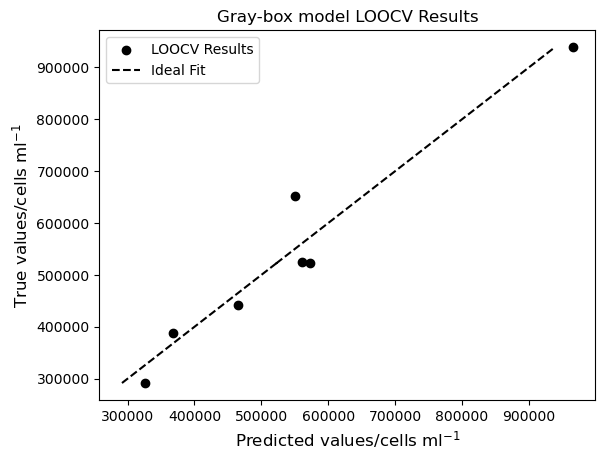

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut

#load features
df=pd.read_csv("./features1/0915_results2_s0.csv")
#convert to Qnfed
tau=df['C2']*df['R2']
sh=(1/df['R1'])+(1/df['R2'])
s0=1/df['R1']
df['tau']=tau
df['sh']=sh
df['s0']=s0

measure_data = pd.read_excel(r'./../repaired_data/Cell count/9-15 cell density.xlsx').to_numpy()
measure_data = measure_data[:,2].reshape(9,3).astype(np.float)
measure_data_norm = np.log10(measure_data)

times=[1,13,25,81,93,105,117,129,175]
input=df.loc[:,['tau','C2']].iloc[times,:].values
input=np.log10(input)
# print(input)

idx=[0,2,3,4,5,6,7]
X = input[idx,]
# yy = np.hstack((measure_data_norm[idx,0], measure_data_norm[idx,1], measure_data_norm[idx,2]))
# xx = np.vstack((xx,xx,xx))

y = np.mean(measure_data_norm,axis=1)[idx]

# Create linear regression object
reg = LinearRegression(fit_intercept=True)

# Create leave-one-out cross-validation object
loo = LeaveOneOut()

# Create arrays to store true and predicted values
true_values = np.zeros(len(X))
pred_values = np.zeros(len(X))

# Perform leave-one-out cross-validation
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg.fit(X_train, y_train)
    pred_values[i] = 10**reg.predict(X_test)
    true_values[i] = 10**y_test

# Create scatter plot of LOOCV results
fig, ax = plt.subplots()
ax.scatter(pred_values, true_values, color='k', label="LOOCV Results")
ax.plot(true_values, true_values, color='k', linestyle='--', label="Ideal Fit")
ax.set_xlabel(r"Predicted values/cells ml$^{-1}$",fontdict={'fontsize': 12})
ax.set_ylabel(r"True values/cells ml$^{-1}$",fontdict={'fontsize': 12})
ax.ticklabel_format(style='plain' , axis='both', scilimits=(0,0))
ax.legend()
ax.set_title("Gray-box model LOOCV Results")
fig.savefig("LOOCV.svg", format='svg')
plt.show()


In [ ]:
data=data_915.load_jiang("./../repaired/9.15 Cell Growth/20190915_Sensor0_Test_50.xlsx")
f=data[:,0]
Z=data[:,1]+1j*data[:,2]
# calib_file=f"./../repaired_data/8.15 Cell Growth/SYS/20190814_Sensor{sensor}_Test_1.xlsx"
# data_sys=data_915.loadfile(calib_file)
# Z_sys=data_sys[:,1]+1j*data_sys[:,2]
# Z=Z-Z_sys


Build Equivalent circuit model

/var/folders/tx/94jf20c57v15dzmr3gt79w7r0000gn/T/ipykernel_19920/1469537900.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  measure_data = measure_data[:,2].reshape(len(times),3).astype(np.float)


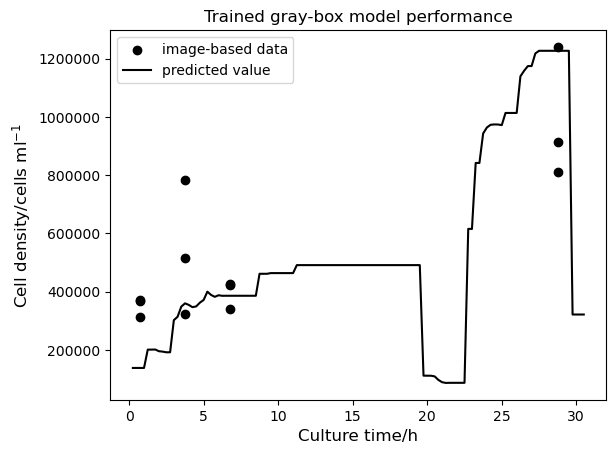

In [ ]:
#final model comparison with raw data
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.ticker as mtick


# times=np.array([1,13,25,81,93,105,117,129,175])
times=np.array([0,13,79,111]) #0815
times=np.array([0,12,24,112])# 0920


result=pd.read_csv("features1/0920_results_s1.csv")
# result1=pd.read_csv("features1/0815_results1_s2.csv")
# result2=pd.read_csv("features1/0815_results2_s2.csv")
# result2['index']+=len(result1['index'])
# result=pd.concat((result1,result2))
measure_data = pd.read_excel(r'./../repaired_data/Cell count/9-20 cell density.xlsx').to_numpy()

times=times+2

measure_data = measure_data[:,2].reshape(len(times),3).astype(np.float)
fig, ax = plt.subplots()

ax.scatter((times+1)/4,measure_data[:,0],color='k',label='image-based data')
ax.scatter((times+1)/4,measure_data[:,1],color='k')
ax.scatter((times+1)/4,measure_data[:,2],color='k')


sh=np.log10(1/result['R2']+1/result['R1'])
c2=np.log10(result['C2'])
q1=np.log10(result['Q1'])
tau=np.log10(result['C2']*result['R2'])


x=result['index']/4
y=10**(regr.intercept_-0.38+np.dot(regr.coef_,[c2,tau])) # 0920
# y=10**(regr.intercept_-2.13+np.dot(regr.coef_,[c2,tau])) # 0815

ax.plot(x,y,label='predicted value',color='k')
ax.set_xlabel("Culture time/h",fontdict={'fontsize': 12})
ax.set_ylabel("Cell density/cells ml$^{-1}$",fontdict={'fontsize': 12})
ax.set_title("Trained gray-box model performance")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))


fig.savefig("0920fin.svg",format="svg")
plt.show()

In [ ]:
testbuild=ih()
# testbuild.list_models()
testbuild.build_model(["CPE0", ("R1",["R2", "C0"])], "ppal_3")
# testbuild.get_model_layout("eqmodel_test1")

Fit impedance

In [ ]:
fit_model=ppal_4

p=lmfit.Parameters()
p.add('Q1',1e-5,min=1e-9, max=1e-2)
p.add('n1',0.7,min=0,max=1)
p.add('R1',20.,min=1, max=500)
p.add('R2',60.,min=1, max=5000)
p.add('C2', 1e-6,min=1e-9, max=1e-3)

mini=lmfit.Minimizer(objective, params=p, fcn_args=(f,Z), nan_policy='omit')
# out1=lmfit.minimize(objective, params=p, method='lstsq', args=(f, Z), nan_policy='omit')
out1=mini.minimize(method='basinhopping')
out2=mini.minimize(params=out1.params, method='lstsq')

lmfit.report_fit(out2.params, min_correl=0.5)
rmse= np.sqrt(np.nanmean((np.abs(fit_model(out2.params,f))-np.abs(Z))**2))
print(rmse)

[[Variables]]
    Q1:  1.1860e-05 (init = 1.186035e-05)
    n1:  0.74781364 (init = 0.7478136)
    R1:  32.0292248 (init = 32.02922)
    R2:  56.2253294 (init = 56.22533)
    C2:  6.2268e-07 (init = 6.226761e-07)
0.8029689779598564


In [ ]:
def z2c(z,f):
    c=1/(2j*np.pi*f*z)
    return c

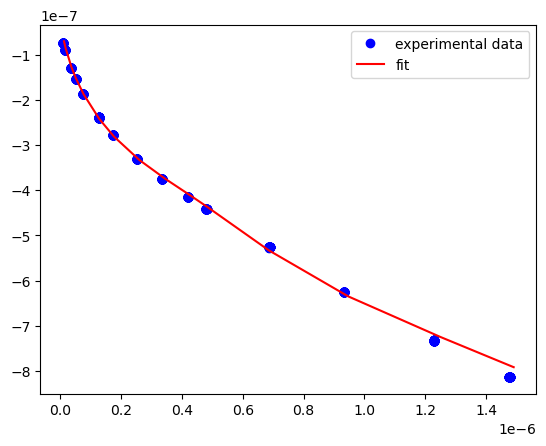

In [ ]:
from matplotlib import pyplot as plt
# plt.plot(Z.real, Z.imag, 'bo', label='experimental data')
# plt.plot(ppal_2(out1.params, f).real, ppal_2(out1.params, f).imag, 'r-', label='fit')
plt.plot(z2c(Z,f).real, z2c(Z,f).imag, 'bo', label='experimental data')
plt.plot(z2c(ppal_4(out2.params, f),f).real, z2c(ppal_4(out2.params, f),f).imag, 'r-', label='fit')
plt.legend()
plt.show()

In [ ]:
params=t2model.make_params(Q0=1e-5, n0=0.7, R0=50, R1=10, R2=10, Q1=1e-6, n1=1)
# result=t1model.fit(data[:,0]+1j*data[:,1],f=data[:,0],method="lstsq",nan_policy='omit')
t2model.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
result = minimize(ppal_2, method='ecmee', nan_policy='omit', burn=300, steps=1000, thin=20,
                     params=t2model.params, is_weighted=False, progress=False)
print(fit_report())

In [ ]:
from matplotlib import pyplot as plt
plt.plot(f, np.real(Z), 'o')
plt.plot(f, np.real(ppal_2(params)), label='best fit')
plt.legend()
plt.show()

In [ ]:
import os
from tqdm import tqdm
data_RG=ih(itype="fma")
data_RG.loadfreq_jiang("./../raw_data/20210722_concept_4.6M/20210722_Parameter_Test_1.txt")

for root, dirs, files in os.walk("./../converted/"):
    os.mkdir(os.path.join(root, "processed"))
    for name in tqdm(files):
        if name.split(".")[-1]=="xlsx":
            # print("processing file:", os.path.join(root, name))
            data_RG.loadfile(os.path.join(root, name))
            data_RG.writefile(os.path.join(root,"processed",name.replace(".xlsx",".csv")))

FileNotFoundError: [Errno 2] No such file or directory: './../raw_data/20210722_concept_4.6M/20210722_Parameter_Test_1.txt'

In [ ]:
data_RG=ih(itype="fma")
data_RG.loadfreq_jiang("./../raw_data/20210722_concept_4.6M/20210722_Parameter_Test_1.txt")
data_RG.loadfile("./../converted/20210722_Sensor0_Test_1.xlsx")
data_RG.writefile("./../converted/processed_1.csv")
# data_RG.fri2fma()
